<a href="https://colab.research.google.com/github/ali1810/Retro_syntheis/blob/main/Retro_synthesis2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q condacolab
import condacolab
condacolab.install()

⏬ Downloading https://github.com/jaimergp/miniforge/releases/latest/download/Mambaforge-colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:47
🔁 Restarting kernel...


In [ ]:
!mamba install -c conda-forge rdkit


                  __    __    __    __
                 /  \  /  \  /  \  /  \
                /    \/    \/    \/    \
███████████████/  /██/  /██/  /██/  /████████████████████████
              /  / \   / \   / \   / \  \____
             /  /   \_/   \_/   \_/   \    o \__,
            / _/                       \_____/  `
            |/
        ███╗   ███╗ █████╗ ███╗   ███╗██████╗  █████╗
        ████╗ ████║██╔══██╗████╗ ████║██╔══██╗██╔══██╗
        ██╔████╔██║███████║██╔████╔██║██████╔╝███████║
        ██║╚██╔╝██║██╔══██║██║╚██╔╝██║██╔══██╗██╔══██║
        ██║ ╚═╝ ██║██║  ██║██║ ╚═╝ ██║██████╔╝██║  ██║
        ╚═╝     ╚═╝╚═╝  ╚═╝╚═╝     ╚═╝╚═════╝ ╚═╝  ╚═╝

        mamba (0.8.0) supported by @QuantStack

        GitHub:  https://github.com/mamba-org/mamba
        Twitter: https://twitter.com/QuantStack

█████████████████████████████████████████████████████████████


Looking for: ['rdkit']

conda-forge/linux-64     Using cache
conda-forge/noarch       Using cache
pkgs/main/noarc

In [ ]:
!pip install onmt
!pip install torchvision 

     |████████████████████████████████| 100 kB 4.2 MB/s 
     |████████████████████████████████| 154 kB 37.0 MB/s 
     |████████████████████████████████| 133 kB 46.1 MB/s 
     |████████████████████████████████| 58 kB 6.3 MB/s 
     |████████████████████████████████| 20.0 MB 59.0 MB/s 
     |████████████████████████████████| 57 kB 5.9 MB/s 
     |████████████████████████████████| 1.0 MB 53.3 MB/s 
     |████████████████████████████████| 734.6 MB 17 kB/s 
     |████████████████████████████████| 53 kB 1.5 MB/s 
     |████████████████████████████████| 53 kB 2.1 MB/s 
     |████████████████████████████████| 125 kB 61.7 MB/s 
  Created wheel for onmt: filename=onmt-1.0.0-py3-none-any.whl size=127640 sha256=dcd0b63ffafa573ff626adba8ea4d0d7ee633fca32bd677f736034e72298d447
  Stored in directory: /root/.cache/pip/wheels/9d/37/4b/acff900261223ac56b18fd6334e7e7d601f1f9b6363b3f2e81
  Created wheel for ConfigArgParse: filename=ConfigArgParse-0.15.1-py3-none-any.whl size=17764 sha256=b2f44da9af7964

In [ ]:
!pip install OpenNMT-py

     |████████████████████████████████| 216 kB 5.1 MB/s 
     |████████████████████████████████| 95 kB 4.0 MB/s 
     |████████████████████████████████| 56 kB 4.3 MB/s 
     |████████████████████████████████| 5.8 MB 38.3 MB/s 
     |████████████████████████████████| 596 kB 49.2 MB/s 
     |████████████████████████████████| 73 kB 1.7 MB/s 
     |████████████████████████████████| 16.0 MB 112 kB/s 
     |████████████████████████████████| 781 kB 36.3 MB/s 
     |████████████████████████████████| 154 kB 58.3 MB/s 
     |████████████████████████████████| 97 kB 6.3 MB/s 
     |████████████████████████████████| 1.1 MB 37.6 MB/s 
     |████████████████████████████████| 3.9 MB 51.4 MB/s 
     |████████████████████████████████| 132 kB 58.1 MB/s 
     |████████████████████████████████| 4.9 MB 44.0 MB/s 
     |████████████████████████████████| 288 kB 59.3 MB/s 
     |████████████████████████████████| 155 kB 61.0 MB/s 
     |████████████████████████████████| 77 kB 5.0 MB/s 
     |███████████████████

In [ ]:
import codecs
import os
import time
import numpy as np
from itertools import count, zip_longest

import torch

from onmt.constants import DefaultTokens
import onmt.model_builder
import onmt.inputters as inputters
import onmt.decoders.ensemble
from onmt.translate.beam_search import BeamSearch, BeamSearchLM
from onmt.translate.greedy_search import GreedySearch, GreedySearchLM
from onmt.utils.misc import tile, set_random_seed, report_matrix
from onmt.utils.alignment import extract_alignment, build_align_pharaoh
from onmt.modules.copy_generator import collapse_copy_scores
from onmt.constants import ModelTask



def build_translator(opt, report_score=True, logger=None, out_file=None):
    if out_file is None:
        out_file = codecs.open(opt.output, "w+", "utf-8")

    load_test_model = (
        onmt.decoders.ensemble.load_test_model
        if len(opt.models) > 1
        else onmt.model_builder.load_test_model
    )
    fields, model, model_opt = load_test_model(opt)

    scorer = onmt.translate.GNMTGlobalScorer.from_opt(opt)

    if model_opt.model_task == ModelTask.LANGUAGE_MODEL:
        translator = GeneratorLM.from_opt(
            model,
            fields,
            opt,
            model_opt,
            global_scorer=scorer,
            out_file=out_file,
            report_align=opt.report_align,
            report_score=report_score,
            logger=logger,
        )
    else:
        translator = Translator.from_opt(
            model,
            fields,
            opt,
            model_opt,
            global_scorer=scorer,
            out_file=out_file,
            report_align=opt.report_align,
            report_score=report_score,
            logger=logger,
        )
    return translator

In [ ]:
from __future__ import unicode_literals
from itertools import repeat

from onmt.utils.logging import init_logger
from onmt.utils.misc import split_corpus
#from onmt.translate.translator import build_translator

import onmt.opts as opts
from onmt.utils.parse import ArgumentParser

import pandas as pd
import numpy as np

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw

In [ ]:
#from utils import *
### Inference file ........###
from urllib.request import urlopen


def predict(mol):

    def iupacToSmiles(name):
        try:
            url = 'http://cactus.nci.nih.gov/chemical/structure/' + name + '/smiles'
            ans = urlopen(url).read().decode('utf8')
            return ans
        except:
            return 'Did not work'

    def smiles_to_IUPAC(smi):
        try:
            url = "https://cactus.nci.nih.gov/chemical/structure/" + smi + "/iupac_name"
            ans = urlopen(url).read().decode('utf8')
            if(len(ans) > 1000):
                return "Name not Available"
            return ans
        except:
            return 'Name Not Available'

    # mol = "N#CC[C@H](O)c1ccccc1"
    molecule = mol[0]
    for c in mol[1:]:
        molecule = molecule + ' ' + c
    # molecule

    # viz moldecule and get its name
    smi = molecule.replace(' ', '')
    m = Chem.MolFromSmiles(smi)

    name = smiles_to_IUPAC(smi)

    # fig = Draw.MolToMPL(m)
    img = Draw.MolToImage(m)
    # imshow(fig)
    # img.save(r"static\molecule.png")
    retro = RetroSynthesis(molecule)

    # run synthesis runs the iterative prediction process
    retro.run_retrosynthesis()

    # display_synthesis displays all predicted reactions
    return name, img, retro.display_synthesis()


In [ ]:
def translate_file(input_filename, output_filename):
    parser = ArgumentParser(description='translation')
    opts.config_opts(parser)
    opts.translate_opts(parser)
    # print(opts)
    args = f'''-model /content/drive/MyDrive/KIT/m16_step_44000.pt
                -src source_products_16.txt
                -output op_16x_4400_50_10.txt
                -batch_size 128
                -replace_unk
                -max_length 200
                -verbose
                -beam_size 50
                -n_best 10
                -min_length 5'''
    opt = parser.parse_args(args)
    # print(opt.model)
    translator = build_translator(opt, report_score=True)

    src_shards = split_corpus(opt.src, opt.shard_size)
    tgt_shards = repeat(None)
    shard_pairs = zip(src_shards, tgt_shards)

    for i, (src_shard, tgt_shard) in enumerate(shard_pairs):
        scores, predictions = translator.translate(
            src=src_shard,
            tgt=tgt_shard,
            #src_dir=opt.src_dir,
            batch_size=opt.batch_size,
            attn_debug=opt.attn_debug
        )

    return scores, predictions


def create_reaction_variants(molecule):
    # creates a variant of the input for each reaction type token
    reactions = ['<RX_1>', '<RX_2>', '<RX_3>', '<RX_4>', '<RX_5>', '<RX_6>',
                 '<RX_7>', '<RX_8>', '<RX_9>', '<RX_10>']
    rxns = [i + ' ' + molecule for i in reactions]

    return rxns


def molecules_to_file(molecules, filename):
    # writes molecules to text files
    with open(filename, 'w') as out:
        for mol in molecules:
            out.write(mol + '\n')


def smile_valid(smile):
    # determines of a predicted SMILES is valid
    s = ''.join(smile.split(' '))
    smile_check = AllChem.MolFromSmiles(s)

    if smile_check:
        return True
    else:
        return False


def canonicalize_smiles(smiles):
    # converts a SMILES string to canonical form
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        return Chem.MolToSmiles(mol, isomericSmiles=True)
    else:
        return ''


def process_smile(smile):
    # Processes tokenized SMILES string into a form that RDKit accepts
    if '> ' in smile:
        # SMILES may have reaction token, this strips the reaction token
        smile = smile.split('> ')[1]

    smile = ''.join(smile.split(' '))
    return smile


def smile_to_mol(smile):
    # converts text SMILES into RDKit Mol object
    return Chem.MolFromSmiles(smile)


def canonicalize_prediction(smiles):
    # converts tokenized predicted SMILES into canonicalized form
    smiles = canonicalize_smiles(process_smile(smiles))

    if smiles == '':
        return smiles
    else:
        return ' '.join([i for i in smiles])


def create_prediction_df(molecule_variants, predictions, scores):
    # Create dataframe of predictions
    # molecule variants - variants of the source product with different reaction tokens
    # predictions - list of lists of predicted SMILES for each molecule variant
    # scores - list of lists for scores corresponding to predictions
    dfs = []

    # for ech variant, create dataframe of input, products, mechanisms and predictions
    for i in range(len(molecule_variants)):
        df_iter = pd.DataFrame({f'Prediction': predictions[i], f'Score': scores[i]})
        df_iter[f'Score'] = df_iter[f'Score'].map(lambda x: x.item())
        df_iter['Input'] = molecule_variants[i]
        df_iter['Product_Molecule'] = df_iter.Input.map(lambda x: x.split('> ')[1])
        df_iter['Mechanism'] = df_iter.Input.map(lambda x: x.split(' ')[0])
        dfs.append(df_iter)

    df = pd.concat(dfs, axis=0)
    df = df.reset_index(drop=True)

    return df


In [ ]:
def clean_predictions(df):
    # cleans a dataframe of predictions

    # drops all invalid SMILES predictions
    df = df[df[f'Prediction'].map(lambda x: smile_valid(x))]
    df = df.reset_index(drop=True)

    # canonicalizes predictions
    df[f'Prediction'] = df[f'Prediction'].map(lambda x: canonicalize_prediction(x))

    # applys stoichiometry check
    df = df[df.apply(lambda row: check_stoichiometry(row['Prediction'], row['Product_Molecule']), axis=1)]

    # removes trivial predictions where product molecule is contained in predicted reactants
    df = df[~df.apply(lambda row: row[f'Product_Molecule'] in row[f'Prediction'], axis=1)]
    df = df.reset_index(drop=True)

    return df


def check_stoichiometry(reactants, product):
    # Checks stoichiometry between product and predicted reactant
    # All product molecules must be contained in the reactant prediction for the prediction to be valid
    reactant_mol = smile_to_mol(process_smile(reactants))
    product_mol = smile_to_mol(process_smile(product))

    reactant_dict = {}
    product_dict = {}

    for i, atom in enumerate(reactant_mol.GetAtoms()):
        atomic_num = atom.GetAtomicNum()

        if atomic_num in reactant_dict.keys():
            reactant_dict[atomic_num] += 1
        else:
            reactant_dict[atomic_num] = 1

    for i, atom in enumerate(product_mol.GetAtoms()):
        atomic_num = atom.GetAtomicNum()

        if atomic_num in product_dict.keys():
            product_dict[atomic_num] += 1
        else:
            product_dict[atomic_num] = 1

    for key in product_dict.keys():
        if not key in reactant_dict.keys():
            return False

        if product_dict[key] > reactant_dict[key]:
            return False

    return True


def process_predictions(df):
    # Clean and score prediction dataframe
    df = clean_predictions(df)
    df.reset_index(inplace=True, drop=True)
    df = score_predictions(df)

    return df


def score_predictions(df):
    # apply scoring function to predictions
    df[f'Prediction_Score'] = df.apply(lambda row:
                                       heuristic_scoring(row[f'Product_Molecule'],
                                                         row[f'Prediction'],
                                                         row[f'Score']), axis=1)
    return df


def calc_ring_change(product, predicted_reactant):
    # returns a score based on the number of ring changes between product and predicted reactants
    # we want to sepect reactant predictions that maximally break down the product
    mol_product = smile_to_mol(process_smile(product))
    mol_reactant = smile_to_mol(process_smile(predicted_reactant))

    product_rings = Chem.rdMolDescriptors.CalcNumRings(mol_product)
    reactant_rings = Chem.rdMolDescriptors.CalcNumRings(mol_reactant)

    # ideally reactants are simpler and contain fewer rings
    return product_rings - reactant_rings


def average_compound_size(smile, ret_max=False):
    # computes average token length of a molecule of string of molecules
    if '.' in smile:
        smile = smile.split('.')
    else:
        smile = [smile]

    lengths = []
    for s in smile:
        lengths.append(len(s.split(' ')))

    if ret_max:
        return max(lengths)
    else:
        return sum(lengths) / len(lengths)


def compound_size_change(product, predicted_reactant):
    # ideally average reactant size is smaller than product size and this value is positive
    return average_compound_size(product) - average_compound_size(predicted_reactant, ret_max=True)

def heuristic_scoring(product, predicted_reactant, model_score, a=100, b=10, c=3):

    # scoring function
    # we want high confidence predictions that reduce complexity going from product to reactant
    # complexity reduction is determined by the number of rings broken and change in average molecule side
    # score terms are weighted by coefficients a and b

    model_score_exp = np.exp(model_score)
    ring_change = calc_ring_change(product, predicted_reactant)
    size_change = compound_size_change(product, predicted_reactant)

    if model_score > -2:
        # only compute full score for high confidence predictions
        # occasionally low confience predictions of a sincle atom cause the ring and size change parameters
        # to blow up and give an inflated score
        score = a * model_score_exp + b * ring_change + c * size_change
    else:
        score = a * model_score_exp

    return score


def check_terminal(smile):
    # determines if a product molecule is considered terminal
    smile = process_smile(smile)

    if 'Mg' in smile:
        # Grignards are considered terminal
        # Grignard forming reactions are not present in the training data and therefore cannot be predicted
        return True
    if smile_to_mol(smile).GetNumAtoms() < 11:
        # Small molecules with less than 11 atoms are considered terminal
        return True
    if len(smile) <= 10:
        # SMILES character length of less than 10 is considered terminal
        return True
    else:
        return False


# dictionary of reaction tokens to mechanisms
rxn_dict = {
    '<RX_1>': 'Heteroatom Alkylation and Arylation',
    '<RX_2>': 'Acylation and Related Processes',
    '<RX_3>': 'C-C Bond Formation',
    '<RX_4>': 'Heterocycle Formation',
    '<RX_5>': 'Protection',
    '<RX_6>': 'Deprotection',
    '<RX_7>': 'Reduction',
    '<RX_8>': 'Oxidation',
    '<RX_9>': 'Functional Group Interconversion',
    '<RX_10>': 'Functional Group Addition'
}


class Reaction():
    # Class for managing a single reaction for retrosynthesis prediction
    # A reaction is instantiated with the tokenized SMILES of the product molecule
    # A score threshold is passed to filter predictions
    # The reaction class receives a set of reactant predictions, filters them, and selects the best prediction of reactants
    # Predicted reactants are checked to see if they are terminal
    # Reaction objects are made to connect in a tree-like structure, and have attributes for parent and child nodes
    def __init__(self, product, score_threshold=36):

        self.product = product

        # product_variants holds versions of the product molecule with different reaction mechanism tokens prepended
        # These will be used for prediction
        # There are 10 reaction mechanisms
        # For each mechanism, 10 predictions are generated via beam search
        # The top prediction (mechanism + predicted reactants) will be selected
        self.product_variants = create_reaction_variants(product)
        self.reactants = None

        self.children = []
        self.parent = None
        self.terminal = False
        self.process_product(self.product)

        self.score_threshold = score_threshold

    def add_prediction(self, df):
        # df is a dataframe of predictions from the product molecule
        # The actual prediction process is run by the Retrosynthesis class to allow for batched prediction
        self.prediction_df = df

        if self.parent:
            # If there is a parent node, predictions containing the parent molecule are discarded
            # This prevents recursive loops where the same two molecules are predicted from one another infinitely
            self.prediction_df = self.prediction_df[~self.prediction_df.apply(lambda row:
                                                                              self.parent.product in row['Prediction'], axis=1)]
            self.prediction_df = self.prediction_df.reset_index(drop=True)

        if self.prediction_df.shape[0] == 0:
            # If the dataframe is empty, indicating no predictions produced valid SMILES or unique molecules, the node is designated terminal
            self.terminal = True

        else:
            # Otherwise, select best prediction
            self.top_prediction = self.prediction_df.nlargest(1, 'Prediction_Score')

            if self.top_prediction.Prediction_Score.values[0] < self.score_threshold:
                # If no predictions pass the threshold, the node is terminal
                self.terminal = True

            else:
                # If a prediction is valid, the reactants are added
                self.add_reactants(self.top_prediction.Prediction.values[0],
                                   self.top_prediction.Mechanism.values[0])

    def process_product(self, product):
        # Checks the product molecule upon instantiation to see if it is terminal
        if check_terminal(product):
            self.terminal = True

    def add_reactants(self, reactant, mechanism):
        # Adds reactant molecules under the reactant and individual_reactant attributes
        # reactants contain the exact predicted string, which may contain multiple molecules
        # individual_reactants accounts for this
        # the reaction mechanism is also recorded
        self.reactants = reactant

        if '.' in reactant:
            self.individual_reactants = reactant.split(' . ')
        else:
            self.individual_reactants = [reactant]

        self.reaction_mechanism = mechanism

    def display_reaction(self, img_size=(400, 400)):
        # Displays product molecule and reactants if they exist
        product_mol = smile_to_mol(process_smile(self.product))
        legend = ['Product']
        mols = [product_mol]

        if self.reactants:
            reactant_mol = smile_to_mol(process_smile(self.reactants))
            legend += [f'Reactants ({rxn_dict[self.reaction_mechanism]})']
            mols += [reactant_mol]

        return Draw.MolsToGridImage(mols, subImgSize=img_size, legends=legend)

    def display_prediction(self, idx, img_size=(400, 400)):
        # Displays any prediction in prediction_df by index
        # Useful for examining predictions that didn't get selected
        prod = smile_to_mol(process_smile(self.prediction_df.iloc[idx].Product_Molecule))
        pred = smile_to_mol(process_smile(self.prediction_df.iloc[idx].Prediction))

        legend = [f'Reactants ({rxn_dict[self.prediction_df.iloc[idx].Mechanism]})',
                  'Product']

        return Draw.MolsToGridImage([pred, prod], legends=legend, subImgSize=img_size)

    def __repr__(self):
        # Repr - prints product SMILES, reactants if they exist, and if the node is terminal
        s = 'Product: ' + process_smile(self.product) + '\n'

        if self.reactants:
            s += 'Reactants: ' + process_smile(self.reactants) + '\n'
            s += 'Reaction Mechanism: ' + rxn_dict[self.reaction_mechanism]

        elif self.terminal:
            s += 'Terminal Reactant'

        else:
            s += 'Reactants not yet identified'

        s += '\n'

        return s


class RetroSynthesis():
    # Retrosynthesis class
    # Manages multiple Reaction nodes
    # Builds a retrosynthesis tree by recursively breaking down reaction nodes
    def __init__(self, molecule, max_depth=15):
        # Class is instantiated with a single target molecule
        # max_depth controls the max number of iterations to avoid infinite loops

        self.molecule = molecule
        self.smile = process_smile(molecule)
        self.max_depth = max_depth
        self.depth = 0
        self.reactions = []
        self.nodes = [Reaction(molecule)]

    def batch_tree_prediction(self):
        # Batch prediction over all active nodes
        # Gathers all nodes, selecting nodes that are active
        # An active node is a node that is not terminal and does not have predicted reactants
        active_nodes = []

        for node in self.nodes:
            if self.is_active(node):
                active_nodes.append(node)

        if active_nodes and self.depth <= self.max_depth:
            reactants = []
            for node in active_nodes:
                # For each active node, we gather the variants (different reaction tokens) of each product
                reactants += node.product_variants

            # All product variants are written to a txt file for prediction
            # Predicting all active products at once in the Retrosynthesis class, compared to running prediction
            # one node at a time in the Reaction class, is much more efficient
            molecules_to_file(reactants, 'source_products_16.txt')

            # Generate predictions
            # print("")
            scores, predictions = translate_file('source_products_16.txt', 'op_16x_3800_50_10.txt')

            # Predictions are stored in a dataframe
            prediction_df = create_prediction_df(reactants, predictions, scores)

            # Predictions are filtered for correct SMILES and scored
            prediction_df = process_predictions(prediction_df)

            for node in active_nodes:
                # For each node, the predictions specific to that product molecule are selected
                # The selected dataframe is passed to the add_prediction function
                node_df = prediction_df[prediction_df.Product_Molecule == node.product]
                node_df = node_df.reset_index(drop=True)
                node.add_prediction(node_df)

                # New child nodes are created based on the prediction results
                self.create_children(node)

            self.depth += 1

            # Batch prediction function is called recursively until either max_depth is reached or there are no active nodes
            self.batch_tree_prediction()

    def create_children(self, node):
        # Creates new child nodes based on prediction results
        # New nodes are only created if a node has predicted reactants and is not terminal
        if node.reactants and not node.terminal:
            for reactant in node.individual_reactants:
                # For each individual reactant, a new node is created
                child_node = Reaction(reactant)

                # For each new node, we set the parent attribute in the new node and add the new node to the children of the parent
                child_node.parent = node
                node.children.append(child_node)

                # new nodes are added to the list of nodes in the Retrosynthesis class
                self.nodes.append(child_node)

    def is_active(self, node):
        # A node is active if there are no predicted reactants and the node is not terminal
        if node.reactants or node.terminal:
            return False
        else:
            return True

    def extract_reaction(self, node):
        # For a given node, this function recursively extracts all predicted reactions that are children to the node
        if node.reactants:
            self.reactions.append([node.product, node.reaction_mechanism,
                                   node.reactants, node.top_prediction.Prediction_Score.values[0]])

        if node.children:
            for child_node in node.children:
                self.extract_reaction(child_node)

    def display_synthesis(self, img_size=(400, 400)):
        # Runs through the predicted reactions in reverse (ie forward synthesis) and displays all predicted steps
        reaction_mols = []
        legend = []

        for reaction in reversed(self.reactions):
            product_mol = smile_to_mol(process_smile(reaction[0]))
            reactant_mol = smile_to_mol(process_smile(reaction[2]))
            legend_iter = [f'Reactant ({rxn_dict[reaction[1]]})', f'Product ({reaction[3]:.4})']
            reaction_mols += [reactant_mol, product_mol]
            legend += legend_iter

        return Draw.MolsToGridImage(reaction_mols, legends=legend, molsPerRow=2, subImgSize=img_size)

    def run_retrosynthesis(self):
        # Runs recursive batch prediction, then extracts reactions from the intial parent node
        self.batch_tree_prediction()
        self.extract_reaction(self.nodes[0])

    def __repr__(self):
        s = f'Retrosynthesis for {self.smile}'

        return s


In [ ]:
from onmt.translate.translator import build_translator

In [ ]:
from onmt.modules import Embeddings, CopyGenerator
from onmt.modules.util_class import Cast
from onmt.utils.misc import use_gpu
from onmt.utils.logging import logger
from onmt.utils.parse import ArgumentParser
from onmt.constants import ModelTask
#from onmt.model_builder import model_task
from onmt import model_builder
#!pip install model_builder


In [ ]:
!pip install Translator

     |████████████████████████████████| 97 kB 3.1 MB/s 


PRED AVG SCORE: -0.0125, PRED PPL: 1.0126
PRED AVG SCORE: -0.0160, PRED PPL: 1.0161
PRED AVG SCORE: -0.0258, PRED PPL: 1.0261
PRED AVG SCORE: -0.0204, PRED PPL: 1.0206
PRED AVG SCORE: -0.0152, PRED PPL: 1.0153
PRED AVG SCORE: -0.0236, PRED PPL: 1.0238
PRED AVG SCORE: -0.0337, PRED PPL: 1.0343
PRED AVG SCORE: -0.0257, PRED PPL: 1.0261
PRED AVG SCORE: -0.0205, PRED PPL: 1.0207
Name Not Available


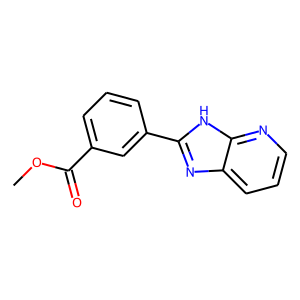

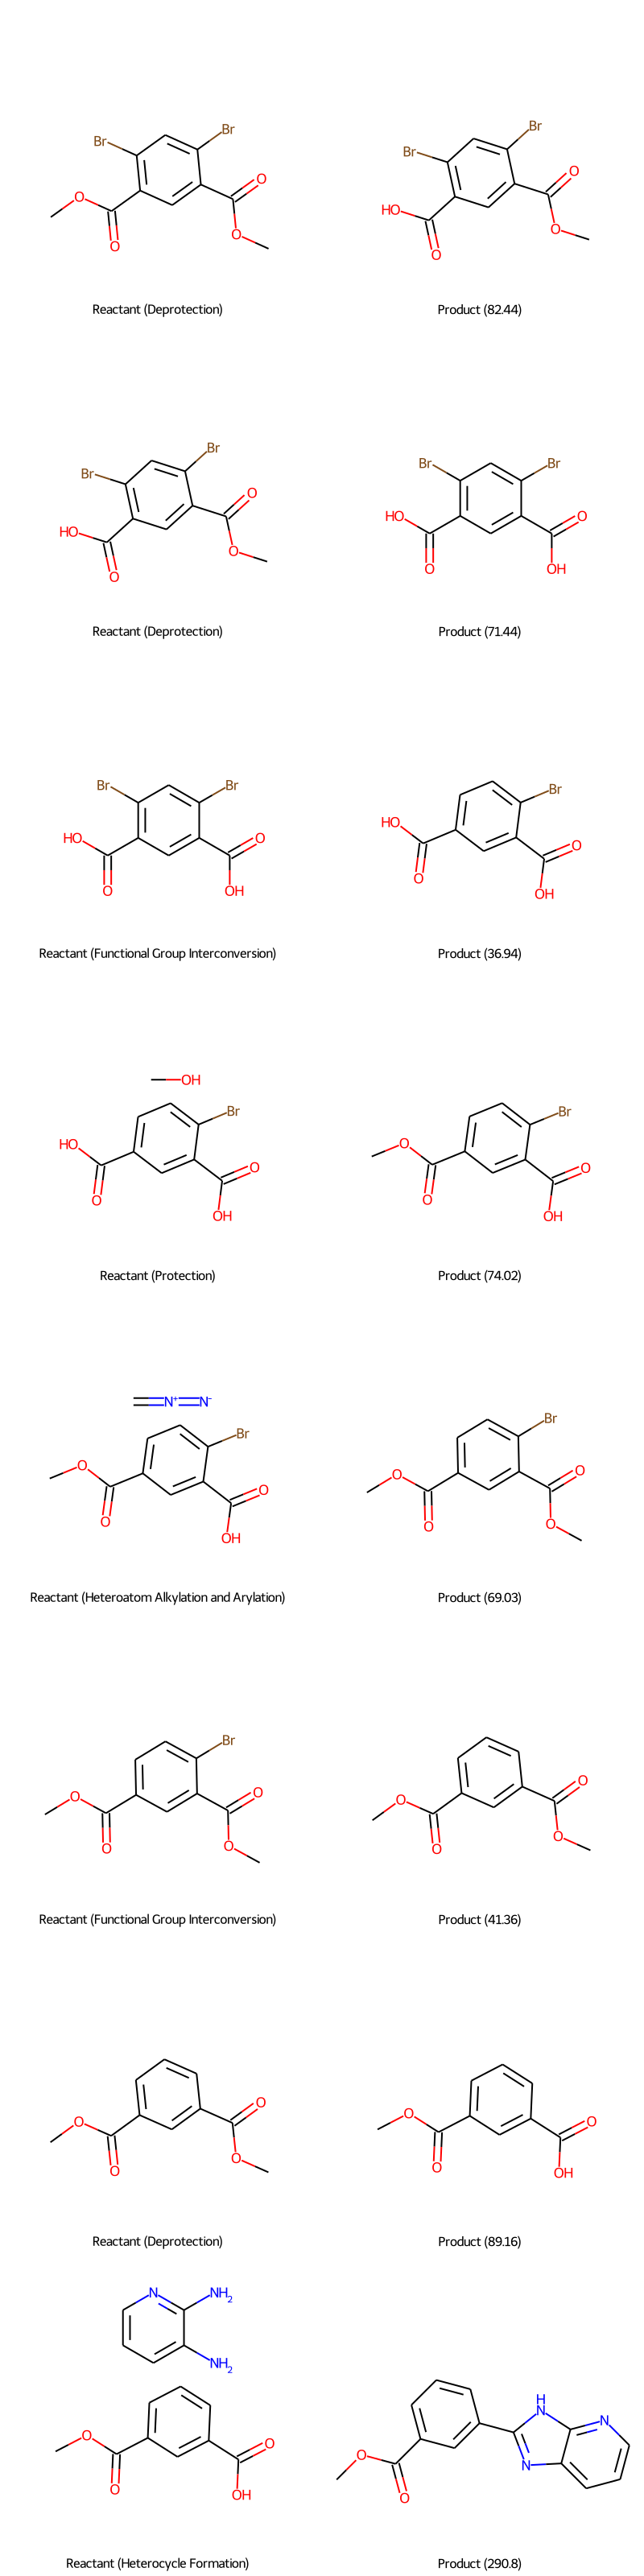

In [ ]:
import matplotlib.pyplot as plt
#text=input("Please Enter smiles "  )
#text= 'CC(=O)OC1=CC=CC=C1C(=O)O'
#text = 'C1 = CC = C (C=C1) C=O'
#text= 'CC=C(C=O)OC1=CC=CC=C1C(=O)CO'
#text= 'C1=CC=(CC(O)C=OH1CC=C1(CC=H)'
text='C O C ( = O ) c 1 c c c c ( - c 2 n c 3 c c c n c 3 [ n H ] 2 ) c 1'
name, img, path = predict(text)
print(name)
img.save('/content/drive/MyDrive/KIT/molecule.png')
path.save('/content/drive/MyDrive/KIT/pathway.png')
from IPython.display import Image, display
display(Image('/content/drive/MyDrive/KIT/molecule.png'))
display(Image('/content/drive/MyDrive/KIT/pathway.png'))
